In [17]:
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import easyocr
import cv2
import numpy as np
import string
from collections import defaultdict
from sklearn.utils import shuffle
import shutil
import csv
from random import sample


# Collect Data


In [18]:
class OCRPlateDataset(Dataset):
    def __init__(self, image_dir=None, samples=None, transform=None):
        self.transform = transform
        self.samples = []

        if samples is not None:
            self.samples = samples  # Use preprocessed (path, label) pairs
        elif image_dir is not None:
            for fname in os.listdir(image_dir):
                if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                    label = os.path.splitext(fname)[0]
                    path = os.path.join(image_dir, fname)
                    self.samples.append((path, label))
        else:
            raise ValueError("Either image_dir or samples must be provided.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")  # or "L" for grayscale
        if self.transform:
            image = self.transform(image)
        return image, label


class ResizeWithAspectRatio:
    def __init__(self, target_height=32, max_width=128):
        self.target_height = target_height
        self.max_width = max_width

    def __call__(self, img):
        w, h = img.size
        new_w = int((w / h) * self.target_height)
        new_w = min(new_w, self.max_width)
        img = img.resize((new_w, self.target_height), Image.BILINEAR)
        # Pad to fixed width
        new_img = Image.new("L", (self.max_width, self.target_height), 255)
        new_img.paste(img, (0, 0))
        return F.to_tensor(new_img)

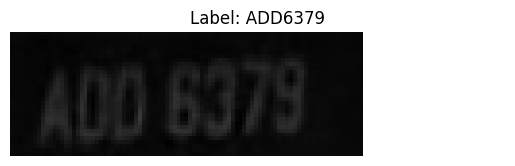

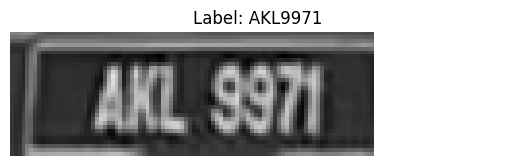

In [19]:
DATASET_PATH = r"C:\Users\MoffyCream\OneDrive - Swinburne Sarawak\COS30018 INTELLIGENT SYSTEMS - OCR\Combined"

items = os.listdir(DATASET_PATH)

train_dir = os.path.join(DATASET_PATH, "train")
test_dir = os.path.join(DATASET_PATH, "test")

transform = transforms.Compose([
    ResizeWithAspectRatio(32, 128)
])

train_dataset = OCRPlateDataset(train_dir, transform=transform)
img_tensor, label = train_dataset[0]
img_pil = F.to_pil_image(img_tensor)

plt.imshow(img_pil, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

test_dataset = OCRPlateDataset(test_dir, transform=transform)
img_tensor, label = test_dataset[0]
img_pil = F.to_pil_image(img_tensor)

plt.imshow(img_pil, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

# Inference on EasyOCR using test set

In [20]:
reader = easyocr.Reader(['en'], gpu=True)
# reader = easyocr.Reader(['en'], recog_network='custom_ocr', gpu=True, model_storage_directory='model', user_network_directory='user_network')

correct = 0
total = 0
incorrect_samples = []

for image_path, label in test_dataset.samples:
    results = reader.readtext(image_path, detail=1)  # Include confidence

    # Combine all detected text parts
    prediction_text = ''.join([text for (_, text, _) in results]).replace(" ", "").upper()
    label_clean = label.replace(" ", "").upper()

    # Calculate average confidence
    if results:
        avg_conf = sum([conf for (_, _, conf) in results]) / len(results)
    else:
        avg_conf = 0.0

    print(f"GT: {label_clean} | Pred: {prediction_text} | Confidence: {avg_conf:.2f}")

    if prediction_text == label_clean:
        correct += 1
    else:
        incorrect_samples.append((image_path, label_clean, prediction_text, avg_conf))

    total += 1

accuracy = correct / total * 100
print(f"\nTotal: {total} | Correct: {correct} | Accuracy: {accuracy:.2f}%")


GT: AKL9971 | Pred: EL9971 | Confidence: 0.11
GT: ALK2728 | Pred: AAUK212 | Confidence: 0.15
GT: BKF2289 | Pred: B23 | Confidence: 0.15
GT: BKR7292 | Pred: BMR7232 | Confidence: 0.39
GT: DET6868 | Pred: DTE833 | Confidence: 0.13
GT: FG6188 | Pred: FG8188 | Confidence: 0.77
GT: JNX3188 | Pred: JUJED | Confidence: 0.14
GT: JTH671 | Pred: JTH671 | Confidence: 0.83
GT: JVK1010 | Pred: JVKYO10 | Confidence: 0.20
GT: JXG4244 | Pred: JNG4244 | Confidence: 0.21
GT: KFT7779 | Pred: KFT7779 | Confidence: 0.81
GT: KS2065Q | Pred: 2065 | Confidence: 0.73
GT: KS5025Q | Pred: KS50250 | Confidence: 0.79
GT: MDT8815 | Pred: 88 | Confidence: 0.23
GT: OBD2666 | Pred: OPD2666 | Confidence: 0.29
GT: OLE7497 | Pred: ME79 | Confidence: 0.12
GT: OPB7031 | Pred: OFB7D | Confidence: 0.17
GT: ORH9138 | Pred: ORH9138 | Confidence: 0.99
GT: ORM4446 | Pred: B6S | Confidence: 0.10
GT: PLP5703 | Pred: PLP5703 | Confidence: 0.72
GT: QAA1089F | Pred: QAAI089F | Confidence: 0.35
GT: QAA1137X | Pred: QMA1ILA7* | Confide

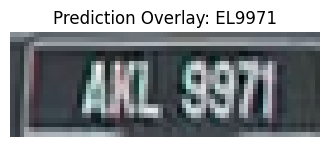

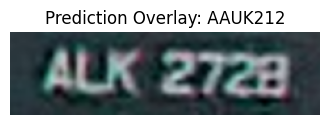

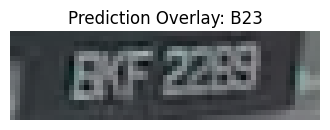

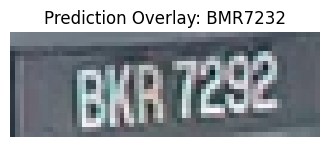

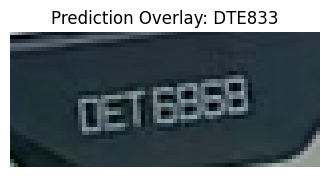

In [21]:

for image_path, _, pred, _ in incorrect_samples[:5]:
    result = reader.readtext(image_path)
    img = cv2.imread(image_path)

    # Convert BGR (OpenCV) to RGB (matplotlib)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(4, 2))
    plt.imshow(img_rgb)
    plt.title(f"Prediction Overlay: {pred}")
    plt.axis("off")
    plt.show()

# Preprocessing

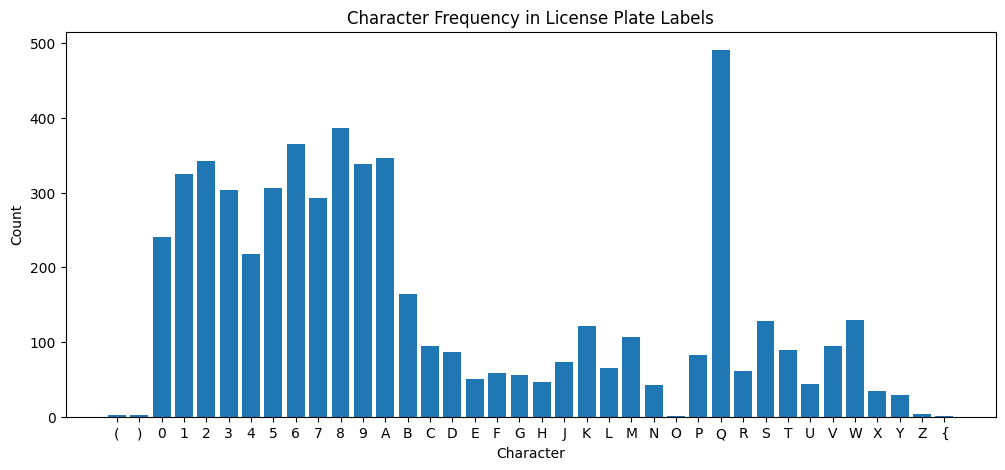

In [22]:
from collections import Counter

# Sample: list of (image_path, label)
char_counter = Counter()

for _, label in train_dataset.samples:
    label = label.replace(" ", "").upper()
    char_counter.update(label)

# Show histogram
import matplotlib.pyplot as plt

chars = sorted(char_counter.keys())
counts = [char_counter[c] for c in chars]

plt.figure(figsize=(12, 5))
plt.bar(chars, counts)
plt.title("Character Frequency in License Plate Labels")
plt.xlabel("Character")
plt.ylabel("Count")
plt.show()


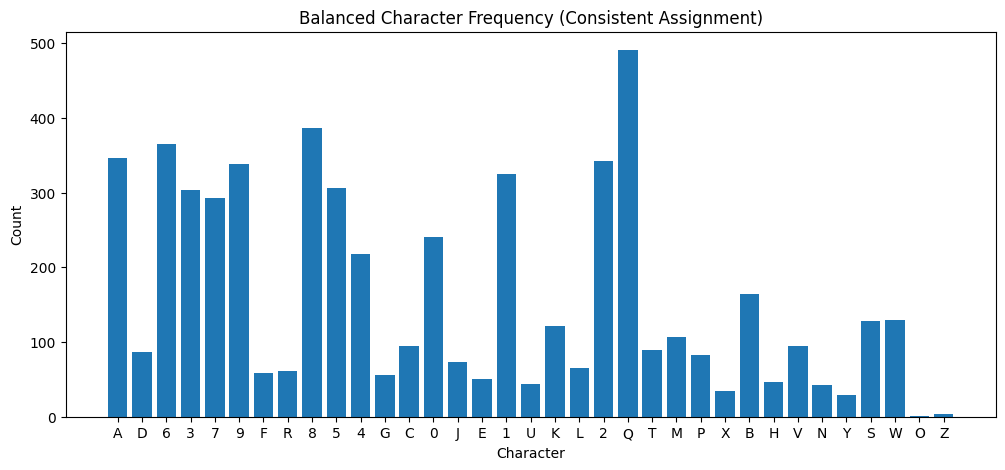

In [23]:
valid_chars = set(string.ascii_uppercase + string.digits)

# Clean labels and keep only valid ones
cleaned_samples = []
for path, label in train_dataset.samples:
    cleaned_label = ''.join(c for c in label if c.upper() in valid_chars)
    if cleaned_label:
        cleaned_samples.append((path, cleaned_label))

# Count all character frequencies first
char_counter = Counter()
for _, label in cleaned_samples:
    char_counter.update(label)

# Assign each sample to the rarest character in its label
char_to_samples = defaultdict(list)

for path, label in cleaned_samples:
    unique_chars = set(label)
    rarest_char = min(unique_chars, key=lambda c: char_counter[c])
    char_to_samples[rarest_char].append((path, label))

# Limit samples per character
max_per_char = 200
final_samples = []

for c, samples in char_to_samples.items():
    samples = shuffle(samples)
    final_samples.extend(samples[:max_per_char])

# Deduplicate and sort
final_samples = sorted(set(final_samples))

# Recalculate and plot
final_counter = Counter()
for _, label in final_samples:
    final_counter.update(label)

plt.figure(figsize=(12, 5))
plt.bar(final_counter.keys(), final_counter.values())
plt.title("Balanced Character Frequency (Consistent Assignment)")
plt.xlabel("Character")
plt.ylabel("Count")
plt.show()

### Preprocess for EasyOCR trainer

- The trainer will load from ./temp_dataset
- Both dirs have the label.csv with header ['filename', 'words']
- The EasyOCR/config_files/en_filtered_config.yaml is adjusted
- The EasyOCR/trainer/train.py and dataset.py is tailored to remove the validation part and pytorch version
- The model will be saved to ./saved_models/enfiltered/
- The entry point for training is EasyOCR/trainer/trainer.ipynb
- The pretrained model will loaded from ./model/english_g2.pth by [Jaided AI](https://jaided.ai/easyocr/modelhub/)



In [24]:
# Define paths
original_train = train_dir
original_test = test_dir
temp_root = "temp_dataset"

temp_train = os.path.join(temp_root, "train")
temp_test = os.path.join(temp_root, "test")

# Copy train and test folders to temp directory
shutil.copytree(original_train, temp_train, dirs_exist_ok=True)
shutil.copytree(original_test, temp_test, dirs_exist_ok=True)

# Generate labels.csv files for train and test directories
def generate_labels_csv(image_dir):
    label_csv_path = os.path.join(image_dir, 'labels.csv')
    with open(label_csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['filename', 'words'])  # header
        for fname in os.listdir(image_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                label = os.path.splitext(fname)[0]
                writer.writerow([fname, label])

generate_labels_csv(temp_train)
generate_labels_csv(temp_test)


In [ ]:
# Run the notebook in the EasyOCR/trainer/trainer.ipynb

# Evaluate trained Model

The saved model, ocr_ft.pth will loaded from ./saved_models/en_filtered/


In [26]:
reader = easyocr.Reader(['en'], recog_network='ocr_ft', gpu=True, model_storage_directory='saved_models/en_filtered', user_network_directory='user_network')
correct = 0
total = 0
incorrect_samples = []

for image_path, label in test_dataset.samples:
    results = reader.readtext(image_path, detail=1)  # Include confidence

    # Combine all detected text parts
    prediction_text = ''.join([text for (_, text, _) in results]).replace(" ", "").upper()
    label_clean = label.replace(" ", "").upper()

    # Calculate average confidence
    if results:
        avg_conf = sum([conf for (_, _, conf) in results]) / len(results)
    else:
        avg_conf = 0.0

    print(f"GT: {label_clean} | Pred: {prediction_text} | Confidence: {avg_conf:.2f}")

    if prediction_text == label_clean:
        correct += 1
    else:
        incorrect_samples.append((image_path, label_clean, prediction_text, avg_conf))

    total += 1

accuracy = correct / total * 100
print(f"\nTotal: {total} | Correct: {correct} | Accuracy: {accuracy:.2f}%")


Progress: |██████████████████████████████████████████████████| 100.0% CompleteGT: AKL9971 | Pred: AKL9971 | Confidence: 0.62
GT: ALK2728 | Pred: ALK2728 | Confidence: 0.60
GT: BKF2289 | Pred: BXF2289 | Confidence: 0.61
GT: BKR7292 | Pred: BMR7292 | Confidence: 0.39
GT: DET6868 | Pred: QET6968 | Confidence: 0.73
GT: FG6188 | Pred: FG6188 | Confidence: 0.95
GT: JNX3188 | Pred: MU3188 | Confidence: 0.48
GT: JTH671 | Pred: JTH671 | Confidence: 0.66
GT: JVK1010 | Pred: JVK1010 | Confidence: 0.57
GT: JXG4244 | Pred: JXG4244 | Confidence: 1.00
GT: KFT7779 | Pred: KFT7779 | Confidence: 0.81
GT: KS2065Q | Pred: S2065 | Confidence: 0.64
GT: KS5025Q | Pred: KS5025Q | Confidence: 0.83
GT: MDT8815 | Pred: QSA885 | Confidence: 0.09
GT: OBD2666 | Pred: QRD2666 | Confidence: 0.91
GT: OLE7497 | Pred: QE7497 | Confidence: 0.99
GT: OPB7031 | Pred: QPB7031 | Confidence: 0.73
GT: ORH9138 | Pred: QRH9138 | Confidence: 0.98
GT: ORM4446 | Pred: QBLBA46 | Confidence: 0.11
GT: PLP5703 | Pred: PLP5703 | Confiden

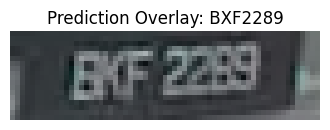

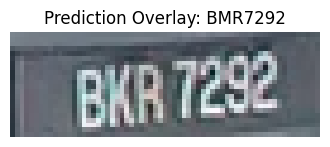

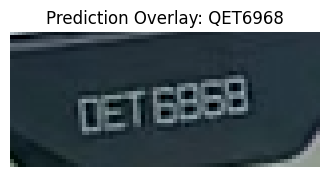

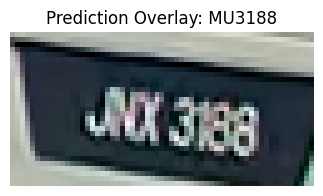

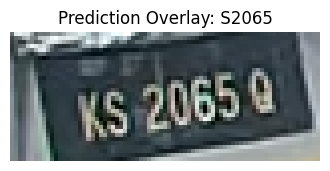

In [27]:

for image_path, _, pred, _ in incorrect_samples[:5]:
    result = reader.readtext(image_path)
    img = cv2.imread(image_path)

    # Convert BGR (OpenCV) to RGB (matplotlib)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(4, 2))
    plt.imshow(img_rgb)
    plt.title(f"Prediction Overlay: {pred}")
    plt.axis("off")
    plt.show()